This file analysis the result from `method_eig`

1. select kappa and ranks, some simple plots of them

2. Reestimate the singular values for each segment based on the selected kappa

**Note that the rank can be changed due to conjugate pair**

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle

from pathlib import Path
from scipy.io import loadmat
from pprint import pprint
from tqdm import trange, tqdm
from scipy.stats import ttest_ind
from collections import defaultdict as ddict
from easydict import EasyDict as edict

%matplotlib inline

In [2]:
# import my own functions
import sys
sys.path.append("../../mypkg")
import importlib

# paras
import paras
importlib.reload(paras);
from paras import paras

# some useful constants
import constants
importlib.reload(constants)
from constants import REGION_NAMES, REGION_NAMES_WLOBE, DATA_ROOT, RES_ROOT, FIG_ROOT

In [4]:
# utils
import utils.matrix
importlib.reload(utils.matrix)
from utils.matrix import eig_sorted

import utils.misc
importlib.reload(utils.misc)
from utils.misc import paras2name, cumsum_cutoff, load_pkl_folder2dict, save_pkl_dict2folder

import utils.standardize
importlib.reload(utils.standardize)
from utils.standardize import minmax, minmax_mat, minmax_pn

In [5]:
# gtvdn
import gtvdn.gtvdn_post
importlib.reload(gtvdn.gtvdn_post)
from gtvdn.gtvdn_post import est_eigvals, update_kp

## Parameters

In [6]:
pprint(paras)

{'Cs': array([1.0e+02, 2.5e+01, 1.0e+01, 5.0e+00, 2.0e+00, 1.0e+00, 5.0e-01,
       2.0e-01, 1.0e-01, 5.0e-02, 1.0e-02]),
 'L': 100.0,
 'Lmin': 200,
 'T': 2,
 'cur_dir': PosixPath('/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method_eig/../../mypkg'),
 'cutoff': 0.6,
 'data_dir': PosixPath('../data'),
 'decimate_rate': 5,
 'downsample_rate': 20,
 'fct': 0.5,
 'fig_dir': PosixPath('../figs'),
 'is_detrend': True,
 'kappa': 3.21,
 'kps': array([1.        , 1.003003  , 1.00600601, 1.00900901, 1.01201201,
       1.01501502, 1.01801802, 1.02102102, 1.02402402, 1.02702703,
       1.03003003, 1.03303303, 1.03603604, 1.03903904, 1.04204204,
       1.04504505, 1.04804805, 1.05105105, 1.05405405, 1.05705706,
       1.06006006, 1.06306306, 1.06606607, 1.06906907, 1.07207207,
       1.07507508, 1.07807808, 1.08108108, 1.08408408, 1.08708709,
       1.09009009, 1.09309309, 1.0960961 , 1.0990991 , 1.1021021 ,
       1.10510511, 1.10810811, 1.11111111, 1.11411411, 1.11711712,
       1.12012

In [7]:
# this parameters only for this file
_paras = edict()
_paras.folder_name = "method_eig"
_paras.save_dir = RES_ROOT/_paras.folder_name
print(f"Load results to {_paras.save_dir}")

Load results to /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method_eig/../../mypkg/../results/method_eig


In [8]:
# Lets save some results
post_paras = edict()

## Load results

In [9]:
# load results
cur_res = load_pkl_folder2dict(RES_ROOT/_paras.folder_name)

Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method_eig/../../mypkg/../results/method_eig/dXXmats_AD.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method_eig/../../mypkg/../results/method_eig/dXXmats_ctrl.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method_eig/../../mypkg/../results/method_eig/Amat_AD.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method_eig/../../mypkg/../results/method_eig/Amat_ctrl.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method_eig/../../mypkg/../results/method_eig/dim_redu_ctrl.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method_eig/../../mypkg/../results/method_eig/dim_redu_AD.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method_eig/../../mypkg/../results/method_eig/can_pts_ctrls.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method_eig/../../mypkg/../results/method_eig/can_pts_AD

In [51]:
# in our case, ranks of two grps should be the same
post_paras.AD_r = cur_res.dim_redu_AD.r
post_paras.ctrl_r = cur_res.dim_redu_ctrl.r

## Select kappa

In [14]:
# sel kappa
_, _, n = cur_res.dim_redu_AD.ndXmats.shape
post_paras.n = n # the length of data

cpts_ctrls_allkp = []
for kp in paras.kps:
    cpts_ctrl_allkp = np.array([update_kp(kp, ix.U0, n, post_paras.ctrl_r, paras) for ix in cur_res.cpts_ctrls])
    cpts_ctrls_allkp.append(cpts_ctrl_allkp)
    

cpts_ADs_allkp = []
for kp in paras.kps:
    cpts_AD_allkp = np.array([update_kp(kp, ix.U0, n, post_paras.AD_r, paras) for ix in cur_res.cpts_ADs])
    cpts_ADs_allkp.append(cpts_AD_allkp)

3.24024024024024

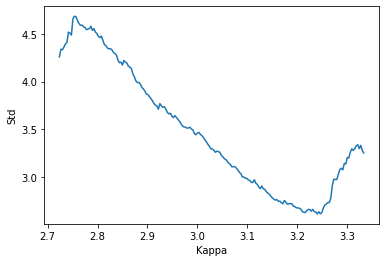

In [37]:
cpts_ctrls_allkp = np.array(cpts_ctrls_allkp)
cpts_ADs_allkp = np.array(cpts_ADs_allkp)
cpts_ctrl_std = cpts_ctrls_allkp.std(axis=1)
cpts_ctrl_mean = cpts_ctrls_allkp.mean(axis=1)

kps_keepidx_ctrl = np.bitwise_and(cpts_ctrls_allkp.mean(axis=1)>=5, cpts_ctrls_allkp.mean(axis=1)<=18)
#kps_keepidx_AD = np.bitwise_and(cpts_ADs_allkp.mean(axis=1)>=2, cpts_ADs_allkp.mean(axis=1)<=18)
#kps_keepidx_2grp = np.bitwise_and(kps_keepidx_AD, kps_keepidx_ctrl)


plt.plot(paras.kps[kps_keepidx_ctrl], cpts_ctrl_std[kps_keepidx_ctrl])
plt.xlabel("Kappa")
plt.ylabel("Std")


sel_kp = paras.kps[kps_keepidx_ctrl][np.argmin(cpts_ctrl_std[kps_keepidx_ctrl])]
post_paras.sel_kp = sel_kp
sel_kp

### change pts under selected kappa

In [38]:
cur_kp = post_paras.sel_kp
ncpts_ctrls_selected = np.array([update_kp(cur_kp, ix.U0, post_paras.n, post_paras.ctrl_r, paras) 
                                 for ix in cur_res.cpts_ctrls])
cpts_ctrls_selected = [cur_cpts.chgMat[cur_ncpt-1, :cur_ncpt] 
                       for cur_ncpt, cur_cpts 
                       in zip(ncpts_ctrls_selected, cur_res.cpts_ctrls)]


ncpts_ADs_selected = np.array([update_kp(cur_kp, ix.U0, post_paras.n, post_paras.AD_r, paras) 
                               for ix  in cur_res.cpts_ADs])
cpts_ADs_selected = [cur_cpts.chgMat[cur_ncpt-1, :cur_ncpt] 
                     for cur_ncpt, cur_cpts 
                     in zip(ncpts_ADs_selected, cur_res.cpts_ADs)]

In [39]:
dwells_ADs_selected = [np.diff(np.concatenate([[1], cpts_selected, [7200]]))/120
                       for cpts_selected 
                       in cpts_ADs_selected]
dwells_ctrls_selected = [np.diff(np.concatenate([[1], cpts_selected, [7200]]))/120
                         for cpts_selected 
                         in cpts_ctrls_selected]

Text(0.5, 1.0, 'AD (4.591) vs Ctrl (7.330)')

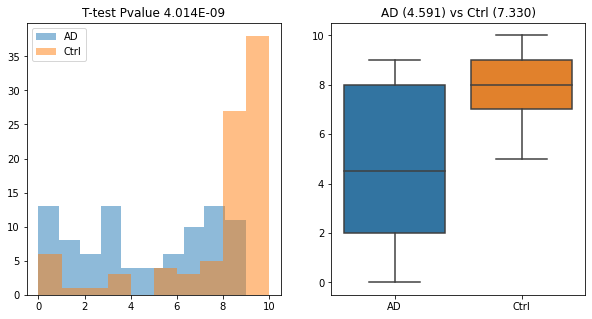

In [40]:
pval = ttest_ind(ncpts_ADs_selected, ncpts_ctrls_selected, equal_var=False).pvalue

plt.figure(figsize=[10, 5])
plt.subplot(121)
plt.hist(ncpts_ADs_selected, alpha=0.5, label="AD")
plt.hist(ncpts_ctrls_selected, alpha=0.5, label="Ctrl")
plt.title(f"T-test Pvalue {pval:.3E}")
plt.legend()

plt.subplot(122)
sns.boxplot(data=[ncpts_ADs_selected, ncpts_ctrls_selected], showfliers=0)
plt.xticks([0, 1], ["AD", "Ctrl"]);
plt.title(f"AD ({ncpts_ADs_selected.mean():.3f}) vs Ctrl ({ncpts_ctrls_selected.mean():.3f})")

## Re-estimate the lambdas for each segment

In [48]:
post_paras.kpidxs = cur_res.dim_redu_AD.kpidxs
eig_vals_ADs = []
eig_vals_ctrls = []

for ix in range(len(cpts_ADs_selected)):
    cur_eig_vals = est_eigvals(cpts_ADs_selected[ix], 
                               cur_res.dim_redu_AD.ndXmats[ix], 
                               cur_res.dim_redu_AD.nXmats[ix], 
                               post_paras.kpidxs
                               )
    eig_vals_ADs.append(cur_eig_vals)
    
for ix in range(len(cpts_ctrls_selected)):
    cur_eig_vals = est_eigvals(cpts_ctrls_selected[ix], 
                               cur_res.dim_redu_ctrl.ndXmats[ix], 
                               cur_res.dim_redu_ctrl.nXmats[ix], 
                               post_paras.kpidxs
                               )
    eig_vals_ctrls.append(cur_eig_vals)

### Select rank

In [144]:
ranks_idxs_AD_selected = []
for ix in range(88):
    tmp_mat = minmax_mat(np.abs(cur_res.eig_vals_ADs[ix]), is_row=False)
    idxs = np.where(tmp_mat.mean(axis=1)>0.5)[0]
    #idxs = cumsum_cutoff(tmp_mat.mean(axis=1), 0.8)
    ranks_idxs_AD_selected.append(idxs)

In [145]:
ranks_idxs_ctrl_selected = []
for ix in range(88):
    tmp_mat = minmax_mat(np.abs(cur_res.eig_vals_ctrls[ix]), is_row=False)
    idxs = np.where(tmp_mat.mean(axis=1)>0.5)[0]
    #idxs = cumsum_cutoff(tmp_mat.mean(axis=1), 0.8)
    ranks_idxs_ctrl_selected.append(idxs)

In [146]:
ranks_AD_selected = np.array([len(rks) for rks in ranks_idxs_AD_selected])
ranks_ctrl_selected = np.array([len(rks) for rks in ranks_idxs_ctrl_selected])

Text(0.5, 1.0, 'AD (7.420) vs Ctrl (6.477)')

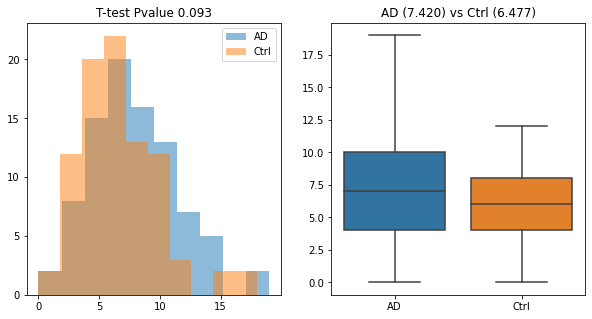

In [147]:
pval = ttest_ind(ranks_AD_selected, ranks_ctrl_selected, equal_var=False).pvalue

plt.figure(figsize=[10, 5])
plt.subplot(121)
plt.hist(ranks_AD_selected, alpha=0.5, label="AD")
plt.hist(ranks_ctrl_selected, alpha=0.5, label="Ctrl")
plt.title(f"T-test Pvalue {pval:.3f}")
plt.legend()

plt.subplot(122)
sns.boxplot(data=[ranks_AD_selected, ranks_ctrl_selected], showfliers=0)
plt.xticks([0, 1], ["AD", "Ctrl"]);
plt.title(f"AD ({ranks_AD_selected.mean():.3f}) vs Ctrl ({ranks_ctrl_selected.mean():.3f})")

## Save updated results

In [53]:
cur_res.post_paras = post_paras

cur_res.eig_vals_ADs = eig_vals_ADs
cur_res.cpts_ADs_selected = cpts_ADs_selected
cur_res.dwells_ADs_selected = dwells_ADs_selected

cur_res.eig_vals_ctrls = eig_vals_ctrls
cur_res.cpts_ctrls_selected = cpts_ctrls_selected
cur_res.dwells_ctrls_selected = dwells_ctrls_selected

In [54]:
save_pkl_dict2folder(_paras.save_dir, cur_res, False)

/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method_eig/../../mypkg/../results/method_eig/dXXmats_AD.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method_eig/../../mypkg/../results/method_eig/dXXmats_ctrl.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method_eig/../../mypkg/../results/method_eig/Amat_AD.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method_eig/../../mypkg/../results/method_eig/Amat_ctrl.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method_eig/../../mypkg/../results/method_eig/dim_redu_ctrl.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method_eig/../../mypkg/../results/method_eig/dim_redu_AD.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN